# Exercise

## Save this work in your anomaly-detection-exercises repository in a file named discrete_anomaly_detection.ipynb.

## Use basic probability to identify anomalous requests. Using the methods covered in this lesson, examine the rest of the features in the api access logs data set.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

### Wrangle

In [2]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [3]:
df.tail()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
13969,97.105.19.58,17/Apr/2019 12:55:12,GET,/api/v1/sales?page=62,HTTP/1.1,200,511544,python-requests/2.21.0
13970,97.105.19.58,17/Apr/2019 12:55:12,GET,/api/v1/sales?page=65,HTTP/1.1,200,511201,python-requests/2.21.0
13971,97.105.19.58,17/Apr/2019 12:55:13,GET,/api/v1/sales?page=73,HTTP/1.1,200,511781,python-requests/2.21.0
13972,97.105.19.58,17/Apr/2019 12:55:13,GET,/api/v1/sales?page=69,HTTP/1.1,200,510136,python-requests/2.21.0
13973,97.105.19.58,17/Apr/2019 12:55:14,GET,/api/v1/sales?page=71,HTTP/1.1,200,510166,python-requests/2.21.0


In [4]:
# our anomalies
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)

In [5]:
# take a look at dataframe
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [6]:
# check dtypes and nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   request_path    13978 non-null  object
 4   http_version    13978 non-null  object
 5   status_code     13978 non-null  object
 6   size            13978 non-null  int64 
 7   user_agent      13978 non-null  object
dtypes: int64(1), object(7)
memory usage: 982.8+ KB


### Cleanup Text

In [7]:
df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')

In [8]:
# now that we have a new colum with size as MB, drop the size column - 'size' is a reserved word
df.drop(columns = 'size', inplace = True)

In [9]:
# get rid of the page numbers and following data from 'request_method' column
df['request_path'] = df.request_path.str.replace(r'\?page=[0-9]+', '', regex=True)

In [10]:
df.head()

,ip,request_method,request_path,http_version,status_code,user_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales,HTTP/1.1,200,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales,HTTP/1.1,200,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales,HTTP/1.1,200,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales,HTTP/1.1,200,python-requests/2.21.0,0.488246


In [11]:
df.tail()

,ip,request_method,request_path,http_version,status_code,user_agent,size_mb
timestamp,,,,,,,
2019-04-17 12:55:14,97.105.19.58,GET,/api/v1/sales,HTTP/1.1,200,python-requests/2.21.0,0.486532
2019-04-21 10:02:41,95.31.18.119,GET,/api/v1/items/,HTTP/1.1,200,python-requests/2.21.0,1.099591
2019-04-17 19:36:41,95.31.16.121,GET,/api/v1/sales/,HTTP/1.1,301,python-requests/2.21.0,0.000958
2019-04-18 19:42:41,97.105.15.120,GET,/api/v1/sales/,HTTP/1.1,301,python-requests/2.21.0,0.002441
2019-04-19 19:42:41,97.105.19.58,GET,/api/v1/sales/,HTTP/1.1,200,python-requests/2.21.0,1.961066


## Detecting Anomalies in Discrete Variables
- **count:** the number of times each unique value appears in the dataset
- **frequencies:** the number of times each unique value appears in the dataset as a percentage of the total; the count - divided by the total number of observations

In [12]:
# the target will be 'request_path'
target = 'request_path'

In [13]:
# check how many unique request_path we have
df.request_path.nunique()

21

In [14]:
# get counts for each request method
df.request_path.value_counts()

/api/v1/sales                      12403
/api/v1/items                       1065
/api/v1/stores                       229
/                                    107
/documentation                       100
/favicon.ico                          26
/api/v1//api/v1/items                 11
/api/v1/items/api/v1/items             7
/api/v1/sales/                         6
/api/v1/items/next_page                5
/api/v1/                               4
/api/v1/itemsitems                     3
/api/v1/store                          3
/api/v1items                           2
/api/v1                                1
/api/v1//api/v1/items/next_page        1
/api/v1/items&page=0                   1
/api/v1/items/                         1
/api/v1/helloclass!                    1
/api/v1/I_DIDNT_DO_IT!!!!              1
/api/V1/HiZach!                        1
Name: request_path, dtype: int64

In [15]:
# turn the above value into a df
df.request_path.value_counts

<bound method IndexOpsMixin.value_counts of timestamp
2019-04-16 19:34:42     /api/v1/sales
2019-04-16 19:34:42     /api/v1/items
2019-04-16 19:34:44     /api/v1/sales
2019-04-16 19:34:46     /api/v1/sales
2019-04-16 19:34:48     /api/v1/sales
                            ...      
2019-04-17 12:55:14     /api/v1/sales
2019-04-21 10:02:41    /api/v1/items/
2019-04-17 19:36:41    /api/v1/sales/
2019-04-18 19:42:41    /api/v1/sales/
2019-04-19 19:42:41    /api/v1/sales/
Name: request_path, Length: 13978, dtype: object>

In [16]:
#df.request_path.value_counts(normalize=True)

In [17]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

In [18]:
rp_df = value_counts_and_frequencies(df.request_path)
rp_df.head()

,count,proba
/api/v1/sales,12403,0.887323
/api/v1/items,1065,0.076191
/api/v1/stores,229,0.016383
/,107,0.007655
/documentation,100,0.007154


#### From here we can find how many unique request paths there are:

<AxesSubplot:>

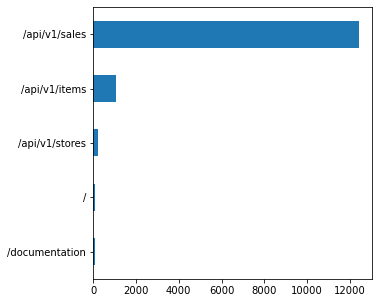

In [19]:
rp_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 5))

In [20]:
status_given_rp = (
    df.groupby('request_path')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_rp')
    .reset_index()
)
status_given_rp.head()

,request_path,status_code,proba_status_given_rp
0,/,200,1.0
1,/api/V1/HiZach!,200,1.0
2,/api/v1,200,1.0
3,/api/v1/,200,1.0
4,/api/v1//api/v1/items,200,1.0


In [21]:
status_given_rp[status_given_rp.proba_status_given_rp < 1]

,request_path,status_code,proba_status_given_rp
8,/api/v1/items,200,0.996244
9,/api/v1/items,499,0.003756
15,/api/v1/sales,200,0.999032
16,/api/v1/sales,499,0.000968
17,/api/v1/sales/,200,0.666667
18,/api/v1/sales/,301,0.333333


In [22]:
status_given_rp[status_given_rp.status_code != '200']

,request_path,status_code,proba_status_given_rp
9,/api/v1/items,499,0.003756
16,/api/v1/sales,499,0.000968
18,/api/v1/sales/,301,0.333333


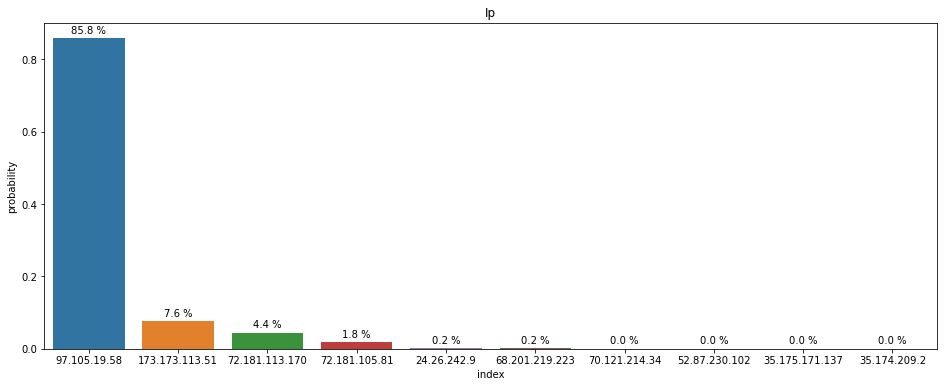

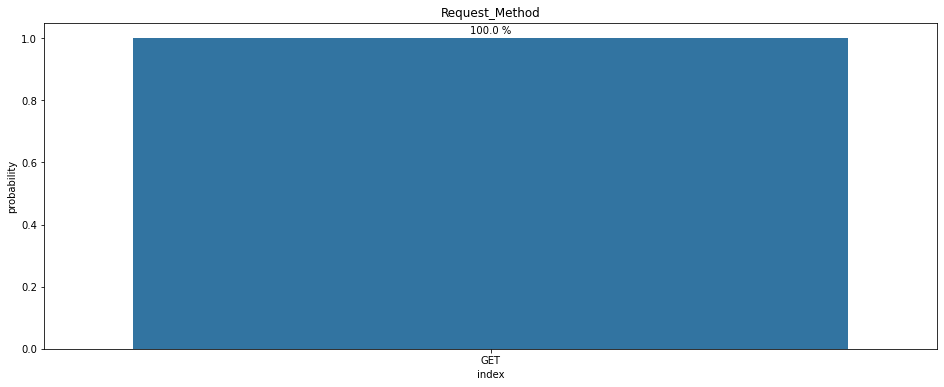

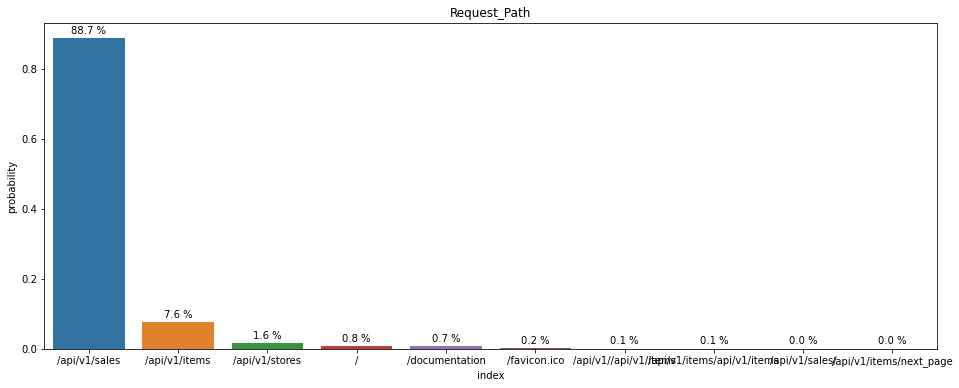

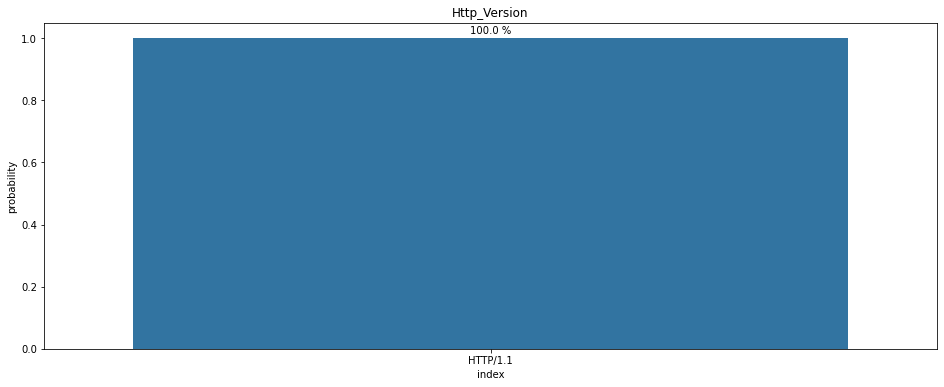

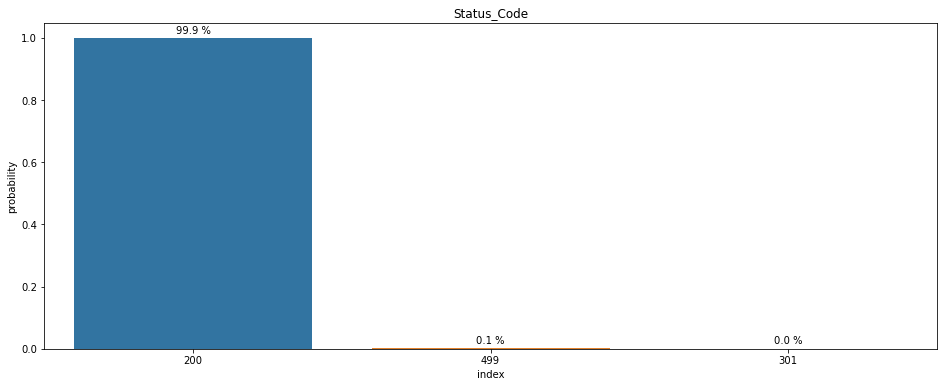

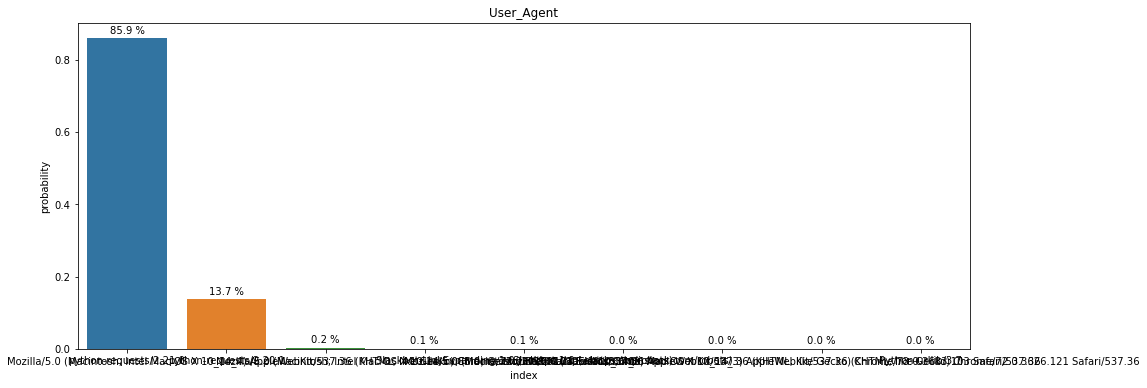

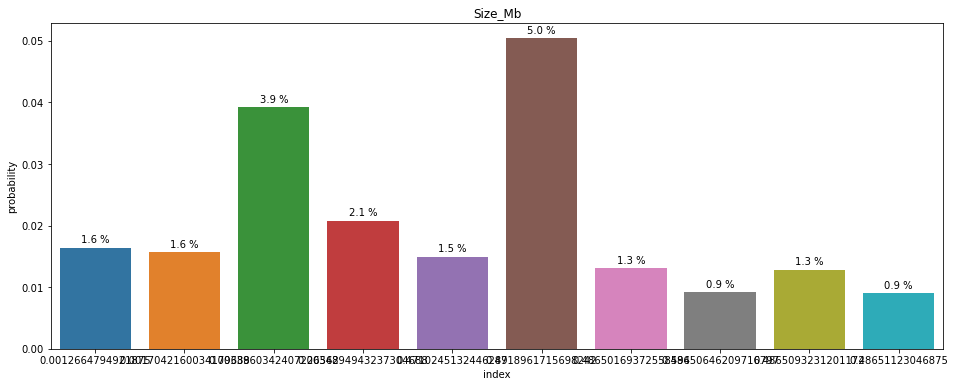

In [24]:
for col in df.columns:
    plt.figure(figsize=(16, 6))
    splot = sns.barplot(x='index', y=col, data=df[col].value_counts(normalize=True).reset_index().sort_values(
        by=col, ascending=False).head(10))
    for p in splot.patches:
        splot.annotate(format(p.get_height() * 100, '.1f') + ' %', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, 8), 
                   textcoords = 'offset points')
    plt.title(col.title())
    plt.ylabel('probability')
    plt.show()